In [2]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import scipy.signal as sig
from IPython.display import Audio
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import torch
import torchaudio
import time
import os

# import my modules:
import helpers as hlp
import importlib
importlib.reload(hlp)

<module 'helpers' from '/Users/joanna.luberadzka/Projects/SpeechEnhanceTest/helpers.py'>

## SPEECH ENHANCEMENT WITH DEEP LEARNING


<img src="images/general.png" alt="alt text" width="600" height="200" class="blog-image">

In thia notebook I am testing 4 different deep-learning based speech enhancement methods from recent years: 
1. DCU_NET (2018): Phase-aware speech enhancement with Deep Complex U-Net
2. SUDO-RM-RF (2019): Efficient neural network for end-to-end general purpose audio source separation. 
3. DENOISER (2021): Real Time Speech Enhancement in the Waveform Domain
4. DEEPFILTERNET (2023): DeepFilterNet: A Low Complexity Speech Enhancement Framework for Full-Band Audio.

Below, I use a few examples of noisy and reverberant speech and let all the different models denoise or de-reverberate those 
signals. Based on that, I can get a feeling of what each method is capable of. 

## 1. Prepare and inspect audio signals:

In [3]:
# -------- Load audio files: --------- 

# Audiofiles for the lecture hall
fs_speech, speech_data = wavfile.read('audios/clean/speech_VCTK_4_sentences.wav')
fs_babblenoise, babblenoise_data = wavfile.read('audios/clean/babblenoise_ACE_lecture_hall.wav')
fs_fannoise, fannoise_data = wavfile.read('audios/clean/fannoise_ACE_lecture_hall.wav')
fs_rir, rir_data = wavfile.read('audios/clean/rir_ACE_lecture_hall.wav') # room impulse response

# make sure all are
speech_data = speech_data.astype('float32')
babblenoise_data = babblenoise_data.astype('float32')
fannoise_data = fannoise_data.astype('float32')
rir_data = rir_data.astype('float32')


/var/folders/hz/fwwq053j7w579c9rw1shw5243xvlkw/T/ipykernel_22026/2645677610.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_speech, speech_data = wavfile.read('audios/clean/speech_VCTK_4_sentences.wav')


In [4]:
# --------- Prepare audio before denoising/dereverberation ----------

# Resample all to the desired sampling rate:
fs=48000
speech_data = sig.resample_poly(speech_data, fs, fs_speech)
babblenoise_data = sig.resample_poly(babblenoise_data, fs, fs_babblenoise)
fannoise_data = sig.resample_poly(fannoise_data, fs, fs_fannoise)
rir_data = sig.resample_poly(rir_data, fs, fs_rir)

# create reverberant version of speech 
revspeech_data=sig.fftconvolve(speech_data,rir_data, 'full', 0)

# Crop sound files to desired length:
L_audio=4*fs# samples
speech_data = speech_data[:L_audio]
revspeech_data = revspeech_data[:L_audio]
babblenoise_data = babblenoise_data[:L_audio]
fannoise_data = fannoise_data[:L_audio]

# create noisy mixture with a desired signal-to-noise ratio
SNR=0
# mix of speech and babble noise
revspeech_data,babblenoise_data=hlp.set_snr(revspeech_data,babblenoise_data,0)
mix_speechbabble=revspeech_data+babblenoise_data
# mix of speech and fan noise
revspeech_data,fannoise_data=hlp.set_snr(revspeech_data,fannoise_data,0)
mix_speechfan=revspeech_data+fannoise_data


# Choose device to compute all models: 
# device="mps" 
device="cpu"

In [5]:
# ----- LISTEN TO AUDIOS: -----

audios_data=[speech_data,revspeech_data,babblenoise_data,fannoise_data, mix_speechbabble,mix_speechfan]
audios_names=["clean speech","reverberant speech","babble noise","fan noise", "speech+babble noise","speech+fan"]

for i, audio in enumerate(audios_data):
    print(audios_names[i])
    display(Audio(data=audio,rate=fs))

clean speech


reverberant speech


babble noise


fan noise


speech+babble noise


speech+fan


In [6]:
# ----- SAVE NOISY SAMPLES: -----
wavfile.write("audios/noisy/revspeech.wav", fs, revspeech_data)
wavfile.write("audios/noisy/mix_speechfan.wav", fs, mix_speechfan)
wavfile.write("audios/noisy/mix_speechbabble.wav", fs, mix_speechbabble)

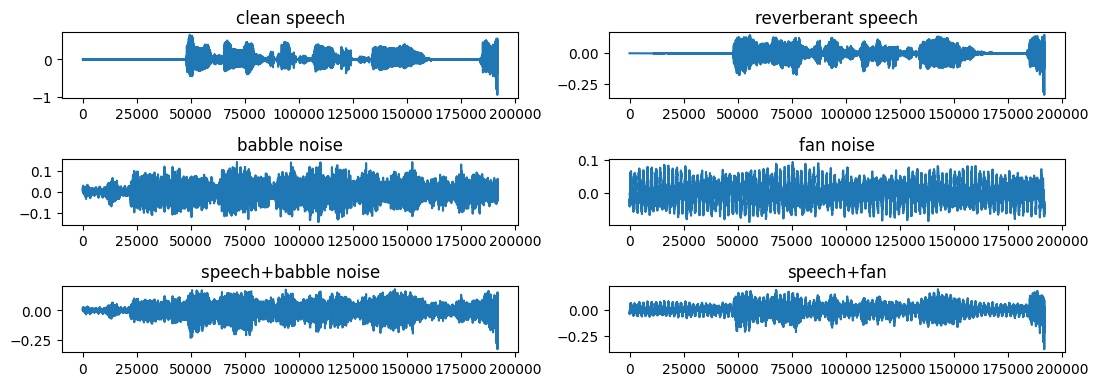

In [7]:
# ----- PLOT WAVEFORMS: -----

plt.figure(figsize=(11,5))
for i, audio in enumerate(audios_data):
    plt.subplot(4,2,i+1)
    plt.plot(audio); plt.title(audios_names[i])
plt.tight_layout()
plt.show()

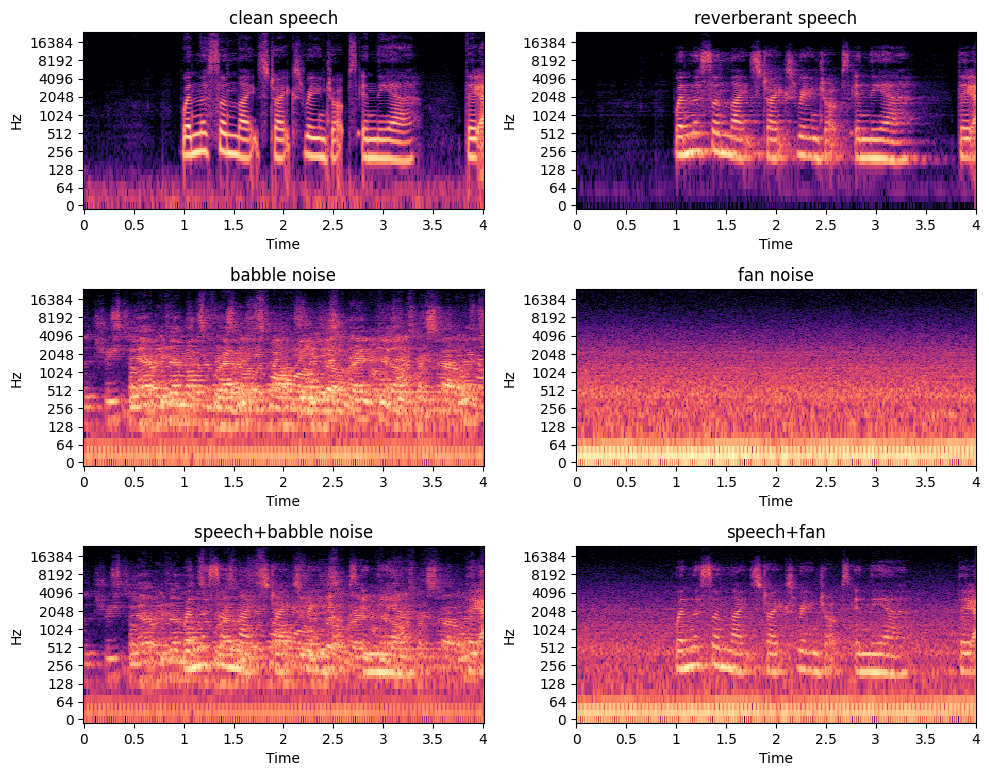

In [8]:
# ----- PLOT SPECTROGRAMS: -----

plt.figure(figsize=(10,10))
for i, audio in enumerate(audios_data):
    plt.subplot(4,2,i+1)
    hlp.plot_spectrogram(audio,fs,audios_names[i])
plt.tight_layout()
plt.show()

##  2. Denoise with deep learning models for comparison:

###  2. 1. DCU-NET

<img src="images/dcunet.png" alt="alt text" width="600" height="200" class="blog-image">

In [9]:
# --------- MODEL 1 : DCU-NET  -----------
# derived from: https://github.com/asteroid-team/asteroid/tree/master
# year: 2018
# architecture: based on u-net
# input: STFT
# output: STFT
# real-time factor: 0.55 

from asteroid.models import DCUNet
model = DCUNet.from_pretrained('JorisCos/DCUNet_Libri1Mix_enhsingle_16k')

def denoise_dcunet(audio_path,fs_model):
        # Sudo-rm-rf separator,
        # Function to denoise with a little bit of pre and post-processing.
        # ------------------------------------------------------
        # load audio
        fs, input_array = wavfile.read(audio_path)
        # resample input audio to match model's fs 
        input_array = sig.resample_poly(input_array, fs_model, fs)
        # array to tensor
        input_tensor=torch.tensor(input_array)
        # Normalize the audio input tensor 
        input_std = input_tensor.std(-1, keepdim=True)
        input_mean = input_tensor.mean(-1, keepdim=True)
        input_tensor = (input_tensor - input_mean) / (input_std + 1e-9)
        # move input data to specified device (here i want to test with cpu/compare with mps)
        input_tensor=input_tensor.to(device)
        # perform denoising and measure time:
        t = time.time()
        output_tensor = model(input_tensor)
        elapsed = time.time() - t
        # Rescale the input sources with the mixture mean and variance
        output_tensor = (output_tensor * input_std) + input_mean
        # Go back to numpy array
        output_array= output_tensor.detach().cpu().numpy()
        # compute and print realtime factor
        print("REALTIME FACTOR= "+ str((elapsed)/(output_array.shape[1]/fs_model)))
        return input_array, output_array


# in a loop: denoise each file, compute realtime factor, display audio 
fs_model=16000 #because this model works on a lower sampling rate then the sound
for filename in os.listdir("audios/noisy/"):
        audio_path="audios/noisy/"+filename
        noisy,target_denoised=denoise_dcunet(audio_path,fs_model)
        wavfile.write(f"audios/denoised/dcunet/sudormrf_{filename}", fs_model, target_denoised.T)
        print("DENOISED FILE: " + filename)
        display(Audio(data=noisy,rate=fs_model))
        display(Audio(data=target_denoised,rate=fs_model))

# remove variables to make sure they are not used in the following cells:
%reset_selective -f "model"
%reset_selective -f "target_denoised"

/Users/joanna.luberadzka/Projects/SpeechEnhanceTest/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/joanna.luberadzka/Projects/SpeechEnhanceTest/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:659: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


REALTIME FACTOR= 0.5780720114707947
DENOISED FILE: mix_speechbabble.wav


REALTIME FACTOR= 0.5419225692749023
DENOISED FILE: revspeech.wav


REALTIME FACTOR= 0.5398489236831665
DENOISED FILE: mix_speechfan.wav


###  2. 2. SUDO-RM-RF
<img src="images/sudormrf.png" alt="alt text" width="600" height="300" class="blog-image">

In [10]:
# --------- MODEL 2 : SUDO-RM-RF -----------
# derived from: https://github.com/etzinis/sudo_rm_rf
# year: 2020
# architecture: based on conv-tas-net
# input: waveform
# output: waveform
# real-time factor: 1.84 

sys.path.append('/Users/joanna.luberadzka/Projects/SpeechEnhanceTest/sudo_rm_rf-master/')
import sudo_rm_rf.dnn
import sudo_rm_rf.dnn.models.improved_sudormrf as improved_sudormrf

# load one of the pre-trained model (reverberant & noisy)
model_path = 'sudo_rm_rf-master/pretrained_models/Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt'
anechoic_separation_model = torch.load(model_path)

# initialize pytorch model class
model = improved_sudormrf.SuDORMRF(
        out_channels=anechoic_separation_model.out_channels,
        in_channels=anechoic_separation_model.in_channels,
        num_blocks=anechoic_separation_model.num_blocks,
        upsampling_depth=anechoic_separation_model.upsampling_depth,
        enc_kernel_size=anechoic_separation_model.enc_kernel_size,
        enc_num_basis=anechoic_separation_model.enc_num_basis,
        num_sources=anechoic_separation_model.num_sources,)

# load weights
model.load_state_dict(anechoic_separation_model.state_dict())

# move model to specified device (here i want to test with cpu/compare with mps)
model.to(device)

# switch on evaluation mode
model.eval()

def denoise_sudormrf(audio_path,fs_model):
        # Sudo-rm-rf separator,
        # Function to denoise with a little bit of pre and post-processing.
        # ------------------------------------------------------
        # load audio
        fs, input_array = wavfile.read(audio_path)
        # resample input audio to match model's fs 
        input_array = sig.resample_poly(input_array, fs_model, fs)
        # array to tensor, prepare dimensions
        input_tensor=torch.tensor(input_array).unsqueeze(0)
        # Normalize the audio input tensor 
        input_std = input_tensor.std(-1, keepdim=True)
        input_mean = input_tensor.mean(-1, keepdim=True)
        input_tensor = (input_tensor - input_mean) / (input_std + 1e-9)
        # move input data to specified device (here i want to test with cpu/compare with mps)
        input_tensor=input_tensor.to(device)
        # perform denoising and measure time:
        t = time.time()
        output_tensor = model(input_tensor.unsqueeze(1))
        elapsed = time.time() - t
        # Rescale the input sources with the mixture mean and variance
        output_tensor = (output_tensor * input_std) + input_mean
        # Go back to numpy array
        output_array= output_tensor.detach().cpu().numpy()
        # compute and print realtime factor
        print("REALTIME FACTOR= "+ str((elapsed)/(output_array.shape[2]/fs_model)))
        return input_array, output_array

# in a loop: denoise each file, compute realtime factor, display audio 
fs_model=16000 #because this model works on a lower sampling rate then the sound
for filename in os.listdir("audios/noisy/"):
        audio_path="audios/noisy/"+filename
        noisy, separated=denoise_sudormrf(audio_path,fs_model)
        # the output of the model is the separated speech and noise, so take speech:
        target_denoised=separated[:,0,:]
        wavfile.write(f"audios/denoised/sudormrf/sudormrf_{filename}", fs_model, target_denoised.T)
        print("DENOISED FILE: " + filename)
        display(Audio(data=noisy,rate=fs_model))
        display(Audio(data=target_denoised,rate=fs_model))

# remove variables to make sure they are not used in the following cells:
%reset_selective -f "model"
%reset_selective -f "target_denoised"

FileNotFoundError: [Errno 2] No such file or directory: 'sudo_rm_rf/pretrained_models/Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt'

###  2. 3. FACEBOOK DENOISER
<img src="images/denoiser.png" alt="alt text" width="400" height="300" class="blog-image">


In [ ]:
# --------- MODEL 2 : FACEBOOK DENOISER -----------
# derived from: https://github.com/facebookresearch/denoiser
# year: 2021
# architecture: 
# input: waveform
# output: waveform
# real-time factor: 0.07

from denoiser import pretrained
from denoiser.dsp import convert_audio
device="cpu"

model = pretrained.dns64().to(device)

def denoise_fbdenoiser(audio_path):
        # Facebook denoiser,
        # Function to denoise with a little bit of pre and post-processing.
        # ------------------------------------------------------
        # load audio 
        fs, input_array = wavfile.read(audio_path)
        # resample input audio to match model's fs 
        input_array = sig.resample_poly(input_array, fs_model, fs)
        # array to tensor, prepare dimensions
        input_tensor=torch.tensor(input_array).unsqueeze(0)
        # prapare audio (using denoiser method)
        input_tensor = convert_audio(input_tensor.to(device), fs_model, model.sample_rate, model.chin)
        with torch.no_grad():
            t = time.time()
            output_tensor = model(input_tensor[None])[0]
            elapsed = time.time() - t
        # Go back to numpy array
        output_array= output_tensor.detach().cpu().numpy()
        # compute and print realtime factor
        print("REALTIME FACTOR= "+ str((elapsed)/(output_array.shape[1]/model.sample_rate)))
        return input_array,output_array

# in a loop: denoise each file, compute realtime factor, display audio 
fs_model= 16000 #because this model works on a lower sampling rate then the sound
for filename in os.listdir("audios/noisy/"):
        audio_path="audios/noisy/"+filename
        noisy,target_denoised=denoise_fbdenoiser(audio_path)
        wavfile.write(f"audios/denoised/fbdenoiser/fbdenoiser_{filename}", fs_model, target_denoised.T)
        print("DENOISED FILE: " + filename)
        display(Audio(data=noisy,rate=fs_model))
        display(Audio(data=target_denoised,rate=fs_model))


# remove variables to make sure they are not used in the following cells:
%reset_selective -f "model"
%reset_selective -f "target_denoised"


REALTIME FACTOR= 0.07548576593399048
DENOISED FILE: mix_speechbabble.wav


REALTIME FACTOR= 0.07510226964950562
DENOISED FILE: revspeech.wav


REALTIME FACTOR= 0.07575374841690063
DENOISED FILE: mix_speechfan.wav


###  2. 4. DEEP FILTER NET
<img src="images/deepfilternet.png" alt="alt text" width="600" height="200" class="blog-image">

In [ ]:
# --------- MODEL 3 : DEEP FILTER NET -----------
# derived from: https://github.com/Rikorose/DeepFilterNet
# year: 2023
# architecture:
# input: 
# output:
# denoising performance:
# dereverberation performance:
# real-time factor

from df.enhance import enhance, init_df, load_audio

model, df_state, _ = init_df()  # Load default model

def denoise_deepfilternet(audio_path):
        # Facebook denoiser,
        # Function to denoise with a little bit of pre and post-processing.
        # ------------------------------------------------------
        # load audio 
        fs, input_array = wavfile.read(audio_path)
        input_tensor=torch.tensor(input_array).unsqueeze(0)
        t = time.time()
        # enhance function contains all preparation and feature extraction 
        output_tensor=enhance(model, df_state, input_tensor)
        elapsed = time.time() - t
        # Go back to numpy array
        output_array= output_tensor.detach().cpu().numpy()
        # compute and print realtime factor
        print("REALTIME FACTOR= "+ str((elapsed)/(output_array.shape[1]/df_state.sr())))
        return input_array,output_array


# in a loop: denoise each file, compute realtime factor, display audio 
for filename in os.listdir("audios/noisy/"):
        audio_path="audios/noisy/"+filename
        noisy,target_denoised=denoise_deepfilternet(audio_path)
        wavfile.write(f"audios/denoised/deepfilternet/deepfilternet_{filename}", fs, target_denoised.T)
        print("DENOISED FILE: " + filename)
        display(Audio(data=noisy,rate=fs))
        display(Audio(data=target_denoised,rate=fs))


# remove variables to make sure they are not used in the following cells:
%reset_selective -f "model"
%reset_selective -f "target_denoised"

2023-09-19 11:25:40 | INFO     | DF | Running on torch 2.0.1
2023-09-19 11:25:40 | INFO     | DF | Running on host BM-JLUBERADZKA.local
2023-09-19 11:25:40 | INFO     | DF | Loading model settings of DeepFilterNet3
2023-09-19 11:25:40 | INFO     | DF | Using DeepFilterNet3 model at /Users/joanna.luberadzka/Library/Caches/DeepFilterNet/DeepFilterNet3
2023-09-19 11:25:40 | INFO     | DF | Initializing model `deepfilternet3`
2023-09-19 11:25:40 | INFO     | DF | Found checkpoint /Users/joanna.luberadzka/Library/Caches/DeepFilterNet/DeepFilterNet3/checkpoints/model_120.ckpt.best with epoch 120
2023-09-19 11:25:40 | INFO     | DF | Running on device cpu
2023-09-19 11:25:40 | INFO     | DF | Model loaded


fatal: Needed a single revision


REALTIME FACTOR= 0.04175645112991333
DENOISED FILE: mix_speechbabble.wav


REALTIME FACTOR= 0.041404545307159424
DENOISED FILE: revspeech.wav


REALTIME FACTOR= 0.040784239768981934
DENOISED FILE: mix_speechfan.wav


### Some observations:

- as I would expecet, it is much easier to cancell fan noise or reverb than to cancel babble noise
- surprisingly, the oldest method (DCU-NET) seems to be the best at cancelling babble noise
- newer models are faster, but not necessarily much better in terms of denoising
- newer models (especially deep filter net) can process audio with sampling rate 48000 (high quality recording)
- all models are quite good at de-reverberating, they can cancel reverberation without adding too much distortion (promising)
